In [1]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2018-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

# Learning with Rewards

Loihi provides the capability to send reinforcement signals to learning enabled connections. This tutorial shows how to reinforce the contingent firing of two neurons by a delayed reward.  This is the fundamental mechanism described by Izhikevich in [1].

[1] Izhikevich EM. Solving the distal reward problem through linkage of STDP
and dopamine signaling. Cerebral Cortex. 2007; 17(10):2443-52

In [2]:
import nxsdk.api.n2a as nx
import matplotlib.pyplot as plt

## Network Architecture

The following figure illustrates the overview of the network:

![Rewards](figures/jupyter_rewards.png)

The details of the network used in the tutorial can be found in the illustration below:

![Rewards Learning Tutorial](figures/rewards_learning_tutorial.png)

The thresholds for compartment c1 and c2 and the synaptic weights in connections connPreSynSpikeToC2 and connPostSynSpikeToC1 are chosen so that c1 and c2 spike immediately upon receiving an incoming spike.

The threshold in compartment c3 and the synaptic weights in connection conn13 and conn23 chosen so that "post-synaptic"
spikes entering from conn13 result in compartment 3 spikes, while the "pre-synaptic" spikes entering from conn23 do not result in compartment 3 spikes.

## Setup and Configure Network

In [3]:
net = nx.NxNet()

### Setup Compartment Prototypes

Compartment parameters are defined as follows:

- vThMant: Actual numerical threshold is 150*(2^6) = 9600.
- compartmentCurrentDecay: current decay set to the maximum decay
- compartmentVoltageDecay: voltage decay set to the maximum decay
- enableSpikeBackprop: Enables back propagating action potentials (post-traces)
- enableSpikeBackpropFromSelf: Activate back propagating action potentials when the compartment spikes

In [4]:
pbasic = nx.CompartmentPrototype(vThMant=150,
                                 compartmentCurrentDecay=4095,
                                 compartmentVoltageDecay=4095)

plrn = nx.CompartmentPrototype(vThMant=150,
                               compartmentCurrentDecay=4095,
                               compartmentVoltageDecay=4095,
                               enableSpikeBackprop=1,
                               enableSpikeBackpropFromSelf=1)

### Setup Learning Rule and Connection Prototypes
The learning rules used for the tag $t$ and weight $w$ variable are given by: 
$$dt=y_0 \cdot x_1 - x_0 \cdot y_1 - 2^{-2}\cdot u_0 \cdot t$$
$$dw=2\cdot u_0\cdot r_1 \cdot t$$

- dt: The tag field is used as the "eligibility trace" described in [1]. This is analogous to standard excitatory STDP learning rule with the exception that the weight change is not immediately stored in the weight variable but the tag variable and it decays exponentially over time. Whereas any spike induced potentiation or depression is conditioned on post or pre synaptic spikes during the learning epoch ($y_0$, $x_0$), the tag decay is unconditionally executed with a decimate exponent of 0 ($u_0$).

- dw: The synaptic weight is adjusted on the existence of a reinforcement signal and the state of the tag ("eligibility trace").

All trace variables used in the $dw$ and $dt$ equations ($x_1$, $y_1$, $r_1$) are further configured by the following parameters:
- x1Impulse, x2Impulse, r1Impulse: The increase in the trace value on the occurrence of a pre-synaptic, post-synaptic, and reinforcement spike.  Maximum value of 127.

- x1TimeConstant, x2TimeConstant, r1TimeConstant: Pre-synaptic, post-synaptic, and reward trace exponential decay time constant set to 4 time steps.

Finally all learning rules leading to synaptic state updates are executed with a certain periodicity which is the duration of the learning epoch (tEpoch). This parameter should in general be set as large as possible (for faster execution) but small enough to ensure at most one spike per tEpoch. A power of two will in general be most efficient. Note: tEpoch has to be the same for all learning rules in the network.

In [5]:
lr = net.createLearningRule(dt='x1*y0-x0*y1-2^-2*u0*t',
                            dw='2*u0*r1*t',
                            x1Impulse=40,
                            x1TimeConstant=4,
                            y1Impulse=40,
                            y1TimeConstant=4,
                            r1Impulse=20,
                            r1TimeConstant=4,
                            tEpoch=2)

connProto2 = nx.ConnectionPrototype(weight=50, enableLearning=1,
                                    learningRule=lr,numTagBits=8,
                                    signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)

connProto1 = nx.ConnectionPrototype(weight=200, numTagBits=8)

### Create Compartments and Connections

In [6]:
# Create Compartments
c1 = net.createCompartment(pbasic)
c2 = net.createCompartment(pbasic)
c3 = net.createCompartment(plrn)

# Create Connections
conn13 = c1.connect(c3, connProto1)
conn23 = c2.connect(c3, connProto2)

### Create and Connect Spike Generators

Configure pre-synaptic, post-synaptic, and reward spike times.  Note that the reward spike arrives later than the pre/post synaptic spikes.

In [7]:
numPorts = 1

# Pre-synaptic spike
preSynapticSpikeTime = [12]
spikeGenPreSyn = net.createSpikeGenProcess(numPorts)
spikeGenPreSyn.addSpikes([0], [preSynapticSpikeTime])
connPreSynSpikeToC2 = spikeGenPreSyn.connect(c2, prototype=connProto1)

# Post-synpatic spike
postSynapticSpikeTime = [16]
spikeGenPostSyn = net.createSpikeGenProcess(numPorts)
spikeGenPostSyn.addSpikes([0], [postSynapticSpikeTime])
connPostSynSpikeToC1 = spikeGenPostSyn.connect(c1, prototype=connProto1)

# Reward spike
rewardTime = [26]
spikeGenReward = net.createSpikeGenProcess(numPorts)
spikeGenReward.addSpikes([0], [rewardTime])
connRewardSpikeToLrnRule = spikeGenReward.connect(lr.reinforcementChannel)

## Configure Probes

Probe the behavior of compartment 3 (c3), the learning connection (conn23), and the reward connection.

In [8]:
conn23PrbSyn = conn23.probe([nx.ProbeParameter.SYNAPSE_WEIGHT,
                             nx.ProbeParameter.SYNAPSE_TAG])
c3Probes = c3.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                     nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                     nx.ProbeParameter.SPIKE])
rewardProbe = connRewardSpikeToLrnRule.probe([nx.ProbeParameter.REWARD_TRACE])

## Run the Network

Run the network for 100 timesteps.

In [9]:
runTime = 100
net.run(runTime)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.02s)
INFO:DRV:      Executing... Done (0.07s)
INFO:DRV:      Processing timeSeries... Done (0.01s)
INFO:DRV:  N2Driver: Finished (0.12s)


## Results

Compartment 3 spikes at timestep 18, and due to the STDP learning rule, the tag field increases.  The reward spike is injected at timestep 26 and the reward trace increases.  The synaptic weight then also increases due to the non-zero reward trace and tag.

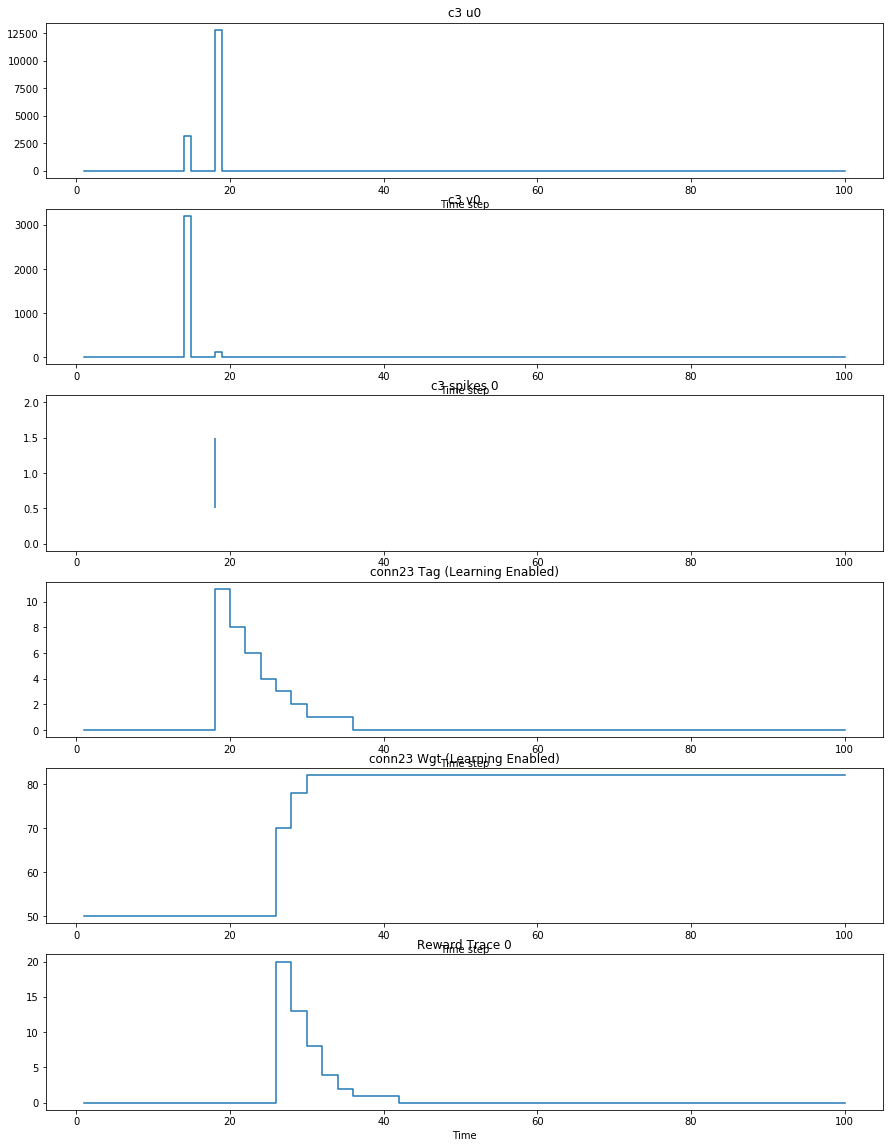

In [10]:
fig1 = plt.figure(1, figsize=(15,20))
ax0 = plt.subplot(6, 1, 1)
c3Probes[0].plot()
plt.title('c3 u0')
plt.subplot(6, 1, 2)
c3Probes[1].plot()
plt.title('c3 v0')
ax1 = plt.subplot(6, 1, 3)
c3Probes[2].plot()
ax1.set_xlim(ax0.get_xlim())
plt.title('c3 spikes 0')
plt.subplot(6, 1, 4)
conn23PrbSyn[1].plot()
plt.title('conn23 Tag (Learning Enabled)')
plt.subplot(6, 1, 5)
conn23PrbSyn[0].plot()
plt.title('conn23 Wgt (Learning Enabled)')
plt.subplot(6, 1, 6)
rewardProbe[0].plot()
plt.title('Reward Trace 0')
plt.xlabel('Time')
plt.show()

.. code-links:: python clear